Data + Sources

Daily Flights ~30,000
https://www.spikeaerospace.com/air-traffic-around-the-globe-over-24-hours/#:~:text=At%20any%20given%20time%2C%20there,in%20the%20United%20States%20alone.

Daily Flights by airport (busy airports)
https://www.id1.de/2022/02/04/airport-statistic-how-many-daily-flights-do-airports-operate/

3 quarters of airports are private use only
https://www.faa.gov/airports/planning_capacity/categories

~97% of airports in the obtained dataset do not seem to have commercial routes

Corroboration of this estimate:
https://www.world-airport-codes.com/us-top-40-airports.html#:~:text=5%2C170%20of%20these%20airports%20are,were%20to%20travel%20by%20car.

Flight Frequency: 30,000 flights/day
2,000,000 passengers/day
~67 passengers per flight
estimate ~100 person capacity

In [4]:
import pandas as pd
import numpy as np
import csv
import math

# Loads in the large dataset
data = pd.read_csv('C:\\Users\\asdf2\Downloads\Aviation_Facilities.csv',low_memory = False)

#Filter Data
useful_columns = ['X','Y','OBJECTID','STATE_CODE','COUNTRY_CODE','LAT_DECIMAL','LONG_DECIMAL']
non_contiguous_states = ['AS','GU','HI','MP','PR','QM','QW','VI','XL']
data = data[useful_columns]
data = data[data['COUNTRY_CODE']=='US']
for code in non_contiguous_states:
    data = data[data['STATE_CODE'] != code]

#Rounds the latitude and longitude to 3 decimals, equivalent to ~.07 miles    
for num in range(0,data.shape[0]):
    data.iloc[num,useful_columns.index("LAT_DECIMAL")] = round(data.iloc[num,useful_columns.index("LAT_DECIMAL")],3)
    data.iloc[num,useful_columns.index("LONG_DECIMAL")] = round(data.iloc[num,useful_columns.index("LONG_DECIMAL")],3)

# Manually entered Routes (The number of routes is the number of other airports which can be reached directly from an aiport)
# Samples are taken from this distribution to estimate the real network
route_info = pd.read_csv("C:\My Files\College\Route count by state.csv")

#Sample a number based on a distribution's cdf
def pick_from_cdf(cdf, values):
    random_number = random.random()
    local_cdf = np.array(cdf)
    local_cdf -= random_number
    index = cdf.index(min(local_cdf[local_cdf>0]) + random_number)
    return values[index]

##Calculate distance between 2 points
def distance(Lat1,Lat2,Lon1,Lon2):
    lat1 = math.pi/180 * Lat1
    lat2 = math.pi/180 * Lat2
    lon1 = math.pi/180 * Lon1
    lon2 = math.pi/180 * Lon2
    return math.acos(math.sin(lat1)*math.sin(lat2)+math.cos(lat1)*math.cos(lat2)*math.cos(lon2-lon1))*6371/1.609

<AxesSubplot:xlabel='X', ylabel='Y'>

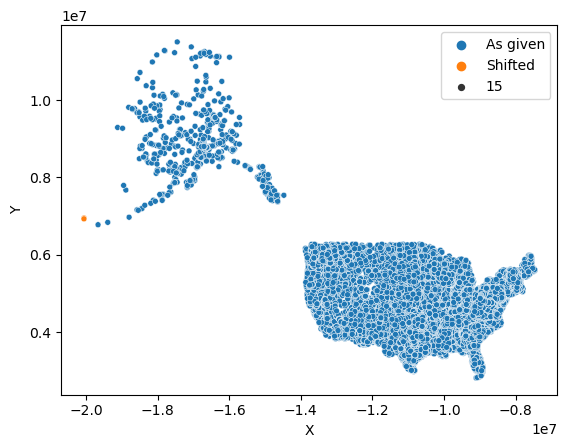

In [5]:
## Use a scatterplot to map the airports
import seaborn as sns
v_data = data.copy() #data.copy() shows the full 20,000 airports, reduced_data.copy() shows the (approximated) commercially connected ones
#v_data = v_data[v_data['STATE_CODE']!='AK'] #Excludes Alaska

# When plotting airports in Alaska, the two airports furthest west have positive X coordinates, causing the map to be distorted
# This block shifts them to the left side of the map, and distinguishes them with a separate color (Marked as 'Shifted')
colors = [] 
start_min = min(v_data['X'])
for num in range(0,v_data.shape[0]):
    if v_data.iloc[num,useful_columns.index('X')] > 0:
        v_data.iloc[num,useful_columns.index('X')] = start_min - 2*10**5-v_data.iloc[num,useful_columns.index('X')]/100
        colors.append('Shifted')
    else:
        colors.append('As given')
sns.scatterplot(x= v_data['X'], y = v_data['Y'], hue = colors, size = 15)

In [6]:
# Potentially useful lines of code that are not directly needed for analysis (yet)

##Calculate the average degree of the real airports
sum(list(route_info['Routes']))/len(list(route_info['Routes']))

##Calculaute the average degree of the approximation of real airports
sum(list(reduced_data['Degree']))/len(list(reduced_data['Degree']))

#View the data for a given state
data[data["STATE_CODE"]=='DC']

## View the percentage of aiports found to have commercial routes in each state
for id_code in np.unique(data["STATE_CODE"]):
    print(100*round(list(route_info['State']).count(id_code)/list(data['STATE_CODE']).count(id_code),4), id_code)

NameError: name 'reduced_data' is not defined

<AxesSubplot:>

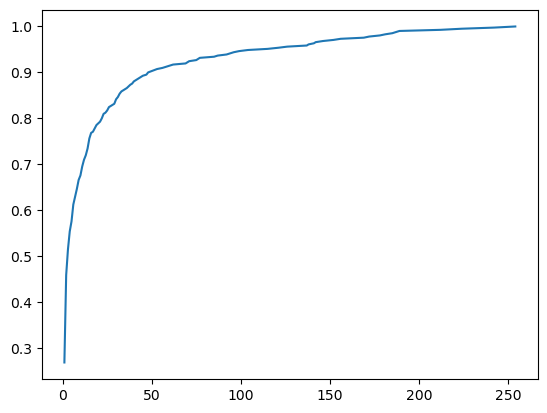

In [7]:
##Plot the cdf of "Number of routes flown at each airport" (i.e. real-world edges)
running_sum = 0

cdf = []
route_count_list = list(route_info["Routes"])
route_count_list.sort()
for value in np.unique(route_count_list):
    running_sum += route_count_list.count(value)
    cdf.append(running_sum/len(route_count_list))
    
sns.lineplot(x = np.unique(route_count_list), y = cdf)

In [8]:
## Randomly remove nodes (can be repurposed for targeted attacks later)
reduced_data = data.copy()
import random
for airport_id in np.unique(data["OBJECTID"]):
    if random.random() < .97: #remove 97% of nodes
        reduced_data = reduced_data[reduced_data["OBJECTID"]!=airport_id]
edge_counts = []

##Add a degree to each airport (sampled from real-world distribution)
for row in range(reduced_data.shape[0]):
    edge_counts.append(pick_from_cdf(cdf,np.unique(route_count_list)))
reduced_data["Degree"] = edge_counts

Below are 3 network generation methods. Each generates an adjacency matrix (A), a list of degrees (degrees), a dataframe with the nodes' properties (reduced_data), and a "node order" list that is used to randomize which properties are assigned to each node if necessary.

Each of these has a unique extension added so that they may be saved simultaneously

When used, "node_order_XX[0]" should return the corresponding dataframe's index for properties assigned to the node represented by A_XX[0,:]

1) An Erdos-Reyni random graph
paramaters are referenced by adding "_ER"

2) A real-world approximation graph
parameters are referenced by adding "_real"

3) A network built via preferential attachment (changing n0 has a notable effect)
parameters are referenced by adding "_PA

In [9]:
## Construct Erdos-Reyni Adjacency Matrix 
A_ER = np.zeros([reduced_data.shape[0],reduced_data.shape[0]])
average_degree = sum(route_info['Routes'])/route_info.shape[0]
for row in range(A_ER.shape[0]):
    for col in range(row+1,A_ER.shape[0]):
        if random.random() <= average_degree/A_ER.shape[0]:
            A_ER[row,col] = 1
            A_ER[col,row] = 1
degrees_ER = np.array(A_ER.sum(axis=1)).reshape(-1)

##Create DataFrame of airports with generated degree
reduced_data_ER = reduced_data.copy()
reduced_data_ER['Degree'] = degrees_ER
reduced_data_ER = reduced_data_ER.reset_index()
    
degrees_ER.sort()

In [10]:
## Construct Realistic Adjacency Matrix 
A_real = np.zeros([reduced_data.shape[0],reduced_data.shape[0]])
stubs = list(reduced_data['Degree'])
stubs.sort(reverse = True)
stubs = np.array(stubs)
for node in range(len(stubs)):
    while stubs[node] > 0 and len(np.nonzero(stubs)[0]) > 1:
        probability = stubs / (stubs.sum() - stubs[node])
        probability[node] = 0 
        if probability.sum() != 1:
            if np.isclose(probability.sum(),1,atol=.00001):
                probability[np.nonzero(probability)[0][-1]] += (1-probability.sum())                
            else:
                print("Something went wrong.", probability.sum())
        connect_to = np.random.choice(len(stubs), min(stubs[node],len(np.nonzero(stubs)[0])-1), replace=False, p = probability)
        for connection in connect_to:
            A_real[node,connection] = 1
            A_real[connection,node] = 1
            stubs[connection] = stubs[connection] - 1
        stubs[node] = 0

## Calculate degree
degrees_real = []
for a in range(0,reduced_data.shape[0]):
    degrees_real.append(int(A_real[a,:].sum()))
degrees_real.sort()

##randomize node properties
node_order_real = np.random.choice(reduced_data.index, reduced_data.shape[0], replace = False)

##Create DataFrame of airports with generated degree
reduced_data_real = reduced_data.copy()
for position in range(len(node_order_real)):
    reduced_data_real.at[node_order_real[position],'Degree'] = degrees_real[position]
reduced_data_real = reduced_data_real.reset_index()

In [11]:
## Construct Prefferred Attachment Adjacency Matrix 

def preferential_attachment_model(n, m, n0, m0):
    n_nodes = n0
    A = np.zeros([n0,n0])
    initially_connected_node = random.randint(0,n0-1)
    for num in range(0,n0):
        if num!= initially_connected_node:
            A[initially_connected_node,num] = 1
            A[num,initially_connected_node] = 1
    
    while n_nodes < n:
        n_nodes += 1
        Old_A = A.copy()
        Old_degrees = np.array(Old_A.sum(axis=1)).reshape(-1)
        A = np.zeros([n_nodes,n_nodes])
        A[:n_nodes-1, :n_nodes-1] = Old_A
        
        prob = []
        for value in Old_degrees:
            numerator = value + m0
            denominator = Old_degrees.sum() + m0*(n_nodes-1)
            prob.append(numerator/denominator)
        
        for new_node in range(0,1):
            connect_to = np.random.choice(n_nodes-1,m, replace=False, p = prob)
            for node in connect_to:
                A[node,new_node+n_nodes-1] = 1
                A[new_node+n_nodes-1,node] = 1
                
    return A
                
        
A_PA = preferential_attachment_model(reduced_data.shape[0],9,30,0)

## Calculate degree
degrees_PA = []
for a in range(0,reduced_data.shape[0]):
    degrees_PA.append(int(A_PA[a,:].sum()))
degrees_PA.sort()

##randomize node properties
node_order_PA = np.random.choice(reduced_data.index, reduced_data.shape[0], replace = False)

##Create DataFrame of airports with generated degree
reduced_data_PA = reduced_data.copy()
for position in range(len(node_order_PA)):
    reduced_data_PA.at[node_order_PA[position],'Degree'] = degrees_PA[position]
reduced_data_PA = reduced_data_PA.reset_index()

In [41]:
demand_table = {'Start':[],'Destination':[]}
degree_array = np.array(reduced_data_real['Degree'])
probability = degree_array/degree_array.sum()
if probability.sum() != 1:
    if np.isclose(probability.sum(),1,atol=.00001):
        probability[np.nonzero(probability)[0][-1]] += (1-probability.sum())                
    else:
        print("Something went wrong.", probability.sum())
while len(demand_table['Start']) < 30000:
    source = np.random.choice(reduced_data_real.shape[0], p = probability)
    target = np.random.choice(reduced_data_real.shape[0], p = probability)
    if source != target:
        demand_table['Start'].append(source)
        demand_table['Destination'].append(target)
demand_table = pd.DataFrame.from_dict(demand_table)
Distances = []
for n in range(30000):
    la1 = reduced_data_real.loc[demand_table.loc[n]['Start']]['LAT_DECIMAL']
    la2 = reduced_data_real.loc[demand_table.loc[n]['Destination']]['LAT_DECIMAL']
    lo1 = reduced_data_real.loc[demand_table.loc[n]['Start']]['LONG_DECIMAL']
    lo2 = reduced_data_real.loc[demand_table.loc[n]['Destination']]['LONG_DECIMAL']
    Distances.append(distance(la1,la2,lo1,lo2))
demand_table['Distance'] = Distances

In [42]:
demand_table

,Start,Destination,Distance
0,309,500,1375.106938
1,502,395,1222.153380
2,470,109,1224.207579
3,345,589,2460.317332
4,77,11,606.320262
...,...,...,...
29995,75,589,4099.487721
29996,328,461,1266.993369
29997,275,386,1289.384281
29998,198,4,225.910956
